In [63]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
from scipy.fft import fft2, fftshift
import matplotlib.pyplot as plt

2.265744099354105 18.395918757475325


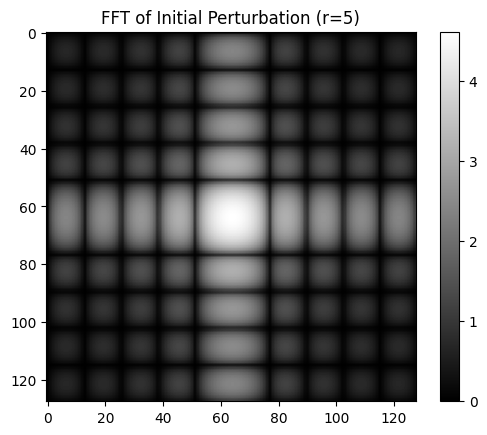

In [64]:
# 参数设置
size = 128
dt = 0.01  # 可能需要调整以确保稳定性
tau = 2.7330
eta = 2.0139
epsilon2 = 50000
Du = 1.0          # A的扩散系数
Dv = tau / epsilon2  # B的扩散系数 ≈0.5122
n_steps = 20000
plot_interval = 100

rangeLeft = eta * (eta + np.sqrt(eta**2 - 4)) / 2
rangeRight = -8 +11.65* rangeLeft

print(rangeLeft, rangeRight)

# 初始化浓度场
A = np.ones((size, size))
B = np.zeros((size, size))
r = 5
cx, cy = size//2, size//2
B[cx-r:cx+r, cy-r:cy+r] = 1.0
A[cx-r:cx+r, cy-r:cy+r] = 1.0

# 对初始B做FFT
F = fft2(B)
F_shifted = fftshift(np.abs(F))

# 可视化频谱（对数尺度）
plt.imshow(np.log1p(F_shifted), cmap='gray')
plt.title(f'FFT of Initial Perturbation (r={r})')
plt.colorbar()
plt.show()

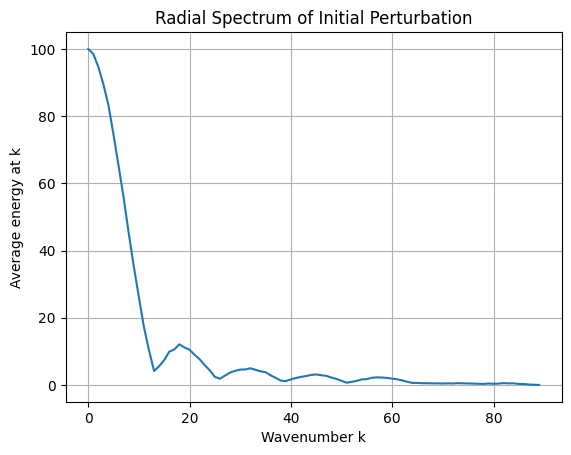

In [65]:
# 假设 B 已定义，size = N
N = B.shape[0]

# 傅里叶变换
F = fft2(B)
F_abs = np.abs(fftshift(F))

# 创建波数网格
kx = np.fft.fftfreq(N) * N
ky = np.fft.fftfreq(N) * N
KX, KY = np.meshgrid(kx, ky)
K = np.sqrt(KX**2 + KY**2)

# 将波数归一化（K范围是 0 到 N/√2）
K = fftshift(K)

# 将频谱能量根据波数做平均（径向平均）
k_max = int(np.max(K))
spectrum = np.zeros(k_max)
counts = np.zeros(k_max)

for i in range(N):
    for j in range(N):
        k_idx = int(K[i, j])
        if k_idx < k_max:
            spectrum[k_idx] += F_abs[i, j]
            counts[k_idx] += 1

spectrum = spectrum / np.maximum(counts, 1)

# 画波数谱
plt.plot(np.arange(k_max), spectrum)
plt.xlabel('Wavenumber k')
plt.ylabel('Average energy at k')
plt.title('Radial Spectrum of Initial Perturbation')
plt.grid(True)
plt.show()

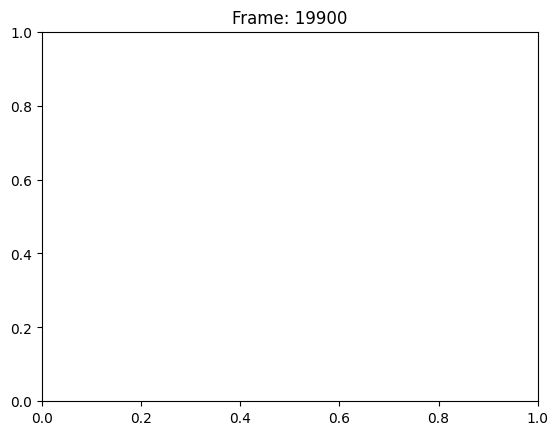

In [66]:
# 预计算所有帧
frames = []
for step in range(n_steps):
    # 计算Laplacian
    LA = (np.roll(A, 1, axis=0) + np.roll(A, -1, axis=0) +
          np.roll(A, 1, axis=1) + np.roll(A, -1, axis=1) - 4*A)
    LB = (np.roll(B, 1, axis=0) + np.roll(B, -1, axis=0) +
          np.roll(B, 1, axis=1) + np.roll(B, -1, axis=1) - 4*B)
    
    # 更新方程
    A_new = A + (Du * LA + (1 - A) - B**2 * A) * dt
    B_new = B + (tau * (eta * B**2 * A - B) + Dv * LB) * dt
    A, B = A_new, B_new
    
    if step % plot_interval == 0:
        frames.append(B.copy())

# 创建动画
fig = plt.figure(figsize=(8,6))
im = plt.imshow(frames[0], cmap='viridis', vmin=0, vmax=1)

def animate(i):
    im.set_array(frames[i])
    plt.title(f'Frame: {i*plot_interval}')
    return [im]

ani = animation.FuncAnimation(
    fig, animate, 
    frames=len(frames),
    interval=50, blit=True
)

# 创建并显示动画
plt.close()

# 保存为MP4文件（需要安装ffmpeg）
ani.save('reaction_diffusion.mp4', writer='ffmpeg', fps=15, dpi=100)

# 在Notebook中显示（可选）
HTML(ani.to_html5_video())